# Wikipedia list of charitable foundations web scraping

In order to find charities in the Panama Papers or other data leaks, we first need to have charities to look for. In addition to their names, we would like to collect identifying information such as their top people's names, their headquarter locations (since the panama paper entities sometimes have addresses), former names of the charity (in case these show up) and other indicative information such as their activity sector and income (for later analysis of hits).

We can find most of this information on wikipedia's list of charitable foundations (see url below). But in order to work with the data, we first need to scrape it off the web (here using the beautiful soup library) and clean it.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

First, we get the wikipedia page in html.

In [2]:
#get html webpage
URL = 'https://en.wikipedia.org/wiki/List_of_charitable_foundations'
r = requests.get(URL)
page_body = r.text
soup = BeautifulSoup(page_body, 'html.parser')

The wikipedia page shows a list of charities where each element of the list is a link to another wikipedia page about the charity in question. We need to extract the name of the charity and link to its wikipedia page from the list.

In [3]:
#The charities are sorted alphabetically. In this list, each element is a letter.
link_sections = soup.findAll('div', class_="div-col columns column-width")

In [4]:
#extract the links from the sections
links_lists = [x.findAll('a') for x in link_sections]
flat_links_list = [item for sublist in links_lists for item in sublist]

In [5]:
flat_links_list[:2]

[<a href="/wiki/AARP#The_AARP_Foundation" title="AARP">AARP Foundation</a>,
 <a href="/wiki/Acorns_Children%27s_Hospice" title="Acorns Children's Hospice">Acorns Children's Hospice</a>]

In [6]:
# Extract the name and link of each charity to a dataframe
charities = pd.DataFrame([(x.text, 'https://en.wikipedia.org' + x.get('href')) for x in flat_links_list], 
                        columns=['name', 'link'])

In [7]:
#Save the data, just in case
charities.to_csv('../../generated/charities/wikipedia_charity_links.csv')

Now we want to extract information about individual charities from the navbox on their linked pages. We use the navbox because it is already semi-structured, making scraping easier. But we need to know what we are looking for, so we collect the available features.

In [8]:
def list_features(charities):
    '''
    Goes through a list of wikipedia pages and extracts the features shown in the table
    
    input: dataframe including a 'Link' column of wikipedia links as strings
    output: a Series of strings
    '''
    
    features = []
    
    #Go through each link
    for index, row in charities.iterrows():
        link = row['link']

        #find the table
        r_link = requests.get(link)
        soup_link = BeautifulSoup(r_link.text, 'html.parser')
        table = soup_link.find('table', class_="infobox vcard")

        #if it exists, find content and extract their type
        if table is not None:
            table_rows = table.findAll('tr')
            for row in table_rows:
                feature = row.find('th')
                if feature is not None:
                    feature = feature.text
                    features.append(feature)
    #return the features as a series of unique strings
    return pd.Series(features).unique()
                    

In [9]:
#Get the list of features we can potentially extract about a charity
list_features(charities)

array(['Formation', 'Founder', 'Type', 'Tax ID no. ', 'Headquarters',
       'Location', 'Members  ', 'CEO', 'Board Chair', 'Subsidiaries',
       'Revenue  ', 'Expenses', 'Staff  ', 'Volunteers  ', 'Website',
       'Formerly called', 'Motto', 'Purpose', 'Region served ',
       'Legal status', 'Membership  ', 'Secretary General', 'Founded',
       'Focus', 'Area served ', 'Method', 'Endowment', 'Product', 'Owner',
       'Key people', 'Employees  ', 'Services', 'Chair',
       'Co-executive director',
       'Revenue .mw-parser-output .nobold{font-weight:normal}(2014) ',
       'Expenses (2014)', 'Employees (2014) ', 'Volunteers (2014) ',
       'Alpha Sigma Tau', 'Scope', 'Colors', 'Symbol', 'Flower', 'Jewel',
       'Publication', 'Philanthropy', 'Chapters', 'Established',
       'Director', 'President', 'Main organ',
       'Revenue .mw-parser-output .nobold{font-weight:normal}(2015) ',
       'Expenses (2015)', 'Affiliations', 'Founders', 'Coordinates',
       'Origins', 'Chief E

Using the features displayed above, we can handcraft lists of more or less synonymous features that will help us create a function capable of handling different type of wikipedia pages.

In [10]:
people_features = ['CEO', 'Secretary General', 'Owner', 'Key people',
                                'Chair', 'Co-executive director', 'President', 'Board Chair',
                                'Chief Executive Officer', 'Board of Directors', 'Executive Director',
                                'National President & CEO', 'Chairman', 'Chief Executive', 
                                'Deputy Secretary General', 'Chair of the Supervisory Board',
                                'Chairman of the Governing Body', 'President/CEO', 'President and CEO',
                                'Board\xa0of directors', 'President of the Board', 'Board of Trustees',
                                'Chair, Adult Advisory Council', 'Leader', 'President, Treasurer', 
                                'President & CEO', 'Executive director', 'Vice president', 'Predecessor',
                                'Chairman of Governors', 'Notable Board Members[1]', 'Board of Directors',
                                'Superior General', 'Honorary President', 'Co-Chairman', 'Managing Director',
                                'Chair World Board', 'President Emeritus', 'Director General']

money_features = ['Revenue', 'Revenue .mw-parser-output .nobold{font-weight:normal}(2016) ',
                                'Revenue .mw-parser-output .nobold{font-weight:normal}(2015) ', 
                                'Revenue .mw-parser-output .nobold{font-weight:normal}(2014) ',
                                'Revenue .mw-parser-output .nobold{font-weight:normal}(2017) ',
                                'Revenue .mw-parser-output .nobold{font-weight:normal}(2016) ',
                                'Net income', 'Total assets', 'Operating income',
                                'Revenue (FY 2015)' ]

hq_features = ['Headquarters', 'Address']

country_features = ['Location', 'Chapters', 'Region ', 'Country']

old_name_features = ['Formerly called', 'Abbreviation', 'Parent organization']

affiliation_features = ['Subsidiaries', 'Affiliation']

purpose_features = ['Purpose', 'Focus', 'Product', 'Services', 'Industry', 'Fields']

Now we can get down to work and extract actual information from the links.

In [11]:
#Helper functions to extract information from a wikipedia page about a charity

#using the list above, go through the charity wikipedia pages and attempt to draw out any possible information
def extract_info_from_table(table):
    '''
    Extracts information from a given html table
    
    Input: an html table containing information about a charity
    Output: list of string of the following shape about a charity (if present):
        [leader1, leader2, leader3, revenue, hq, location, other_names, subsidiaries, purpose]
    '''
    
    #placeholders for the information we want
    #note that we have 3 slots for leaders because there may be several important people listed (CEO, Chairman, etc...)
    leader1 = None
    leader2 = None
    leader3 = None
    leader1_set = False
    leader2_set = False
    leader3_set = False
    revenue = None
    hq = None
    location = None
    other_names = None
    subsidiaries = None
    purpose = None
        
    if table is not None:
        #for each table row
        table_rows = table.findAll('tr')
        for row in table_rows:
            #find the feature and its value
            feature = row.find('th')
            value = row.find('td')
            if feature is not None and value is not None:
                #cast them to strings
                feature = feature.text
                value = value.text
                
                #check which category the feature belongs to and insert the value in a placeholder
                if feature in people_features:
                    if leader1_set == False:
                        leader1 = value
                        leader1_set = True
                    elif leader2_set == False:
                        leader2 = value
                        leader2_set = True
                    elif leader3_set == False:
                        leader3 = value
                        leader3_set = True
                elif feature in money_features:
                    revenue = value
                elif feature in hq_features:
                    hq = value
                elif feature in country_features:
                    location = value
                elif feature in old_name_features:
                    other_names = value
                elif feature in affiliation_features:
                    subsidiaries = value
                elif feature in purpose_features:
                    purpose = value
                    
    #return the information
    return [leader1, leader2, leader3, revenue, hq, location, other_names, subsidiaries, purpose]
    
        

def extract_info_from_link(link):
    '''
    Given a wikipedia link, find its navbox and extract information
    
    Input: wikipedia link
    Output: list of string of the following shape about a charity (if present):
            [leader1, leader2, leader3, revenue, hq, location, other_names, subsidiaries, purpose]
    
    '''
    r_link = requests.get(link)
    soup_link = BeautifulSoup(r_link.text, 'html.parser')
    table = soup_link.find('table', class_="infobox vcard")
    return extract_info_from_table(table)

Using these helper functions, we iterate through the links and check each one for information.

In [12]:
detailed_charities = []
for index, row in charities.iterrows():
    name = row['name']
    link = row['link']
    charity_details = extract_info_from_link(link)
    #we make sure to save the charity's name as well
    charity_details.insert(0, name)
    detailed_charities.append(charity_details)

In [13]:
charities_detailed = pd.DataFrame(detailed_charities,
                                  columns=['name', 'Leader 1', 'Leader 2', 'Leader 3',
                                           'Revenue', 'Headquarters', 'Location', 'Other names', 'Subsidiaries',
                                          'Purpose'])
charities_detailed.head(5)

,name,Leader 1,Leader 2,Leader 3,Revenue,Headquarters,Location,Other names,Subsidiaries,Purpose
0,AARP Foundation,Jo Ann Jenkins,Joan R. Ruff,None,None,"Washington, D.C., U.S.","Offices in all 50 U.S. states, the District of...",American Association of Retired Persons,AARP FoundationAARP Services IncLegal Counsel ...,None
1,Acorns Children's Hospice,None,None,None,None,None,None,None,None,To provide palliative care
2,Action Against Hunger,None,None,None,None,"New York, USA; Toronto, Canada; London, UK; Pa...",None,None,None,To end child malnutrition whilst providing com...
3,Action Deafness,None,None,None,None,None,None,None,None,None
4,ActionAid,Adriano Campolina,None,None,None,None,Johannesburg (Headquarters),None,None,ActionAid works with communities to reduce pov...


In [14]:
charities_detailed.describe()

,name,Leader 1,Leader 2,Leader 3,Revenue,Headquarters,Location,Other names,Subsidiaries,Purpose
count,324,147,31,4,32,95,138,39,6,127
unique,324,147,31,4,32,86,129,39,6,122
top,Engineers Without Borders,"William ""Bill"" Sweeney","Dorothy Stoneman, John Valverde",Elizabeth Scott[1],"$573,870,254[1]","Washington, D.C., U.S.","Washington, D.C.",BBBSA,The Florence G Heller JCC Association Research...,Humanitarian
freq,1,1,1,1,1,2,3,1,1,3


We see that this is still relatively messy, with lots of information missing, and sometimes misstored columns or mulitple values in each field. This is okay, though, because the names are neat and they will be our primary point of comparison with the panama papers. Once we have narrowed down the charities based on the names, if we need more information about the (hopefully) small subset of charities, we can do more cleaning then. 

Meanwhile, let's save this information and analyse it a bit more carefully.

In [15]:
#Save the data as a csv file
charities_detailed.to_csv('../../generated/wikipedia/wikipedia_charity_info.csv')

In [16]:
#reload the data to make sure it's okay
df = pd.read_csv('../../generated/wikipedia/wikipedia_charity_info.csv', index_col=0)
df.head(5)

,name,Leader 1,Leader 2,Leader 3,Revenue,Headquarters,Location,Other names,Subsidiaries,Purpose
0,AARP Foundation,Jo Ann Jenkins,Joan R. Ruff,NaN,NaN,"Washington, D.C., U.S.","Offices in all 50 U.S. states, the District of...",American Association of Retired Persons,AARP FoundationAARP Services IncLegal Counsel ...,NaN
1,Acorns Children's Hospice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To provide palliative care
2,Action Against Hunger,NaN,NaN,NaN,NaN,"New York, USA; Toronto, Canada; London, UK; Pa...",NaN,NaN,NaN,To end child malnutrition whilst providing com...
3,Action Deafness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ActionAid,Adriano Campolina,NaN,NaN,NaN,NaN,Johannesburg (Headquarters),NaN,NaN,ActionAid works with communities to reduce pov...


Looks like it survived the csv. Time to analyse!

We start with the names, since they are the most important part of the charity for our research (primary point of comparison with the panama papers).

To figure out how often we might accidentally come across matches based on rather generic names, we analyse the words that make up the names.

Looks like it survived the csv. Time to analyse!

We start with the names, since they are the most important part of the charity for our research (primary point of comparison with the panama papers).

To figure out how often we might accidentally come across matches based on rather generic names, we analyse the words that make up the names.

In [17]:
names = df['name']

#Separate the words in the names
split_names = names.str.split()
words_in_names = pd.DataFrame([word for name in split_names for word in name], columns=['Words'])

#Count how often specific words appear
words_in_names['Count'] = 1
word_frequency = words_in_names.groupby('Words').count().reset_index()\
                    .sort_values(by='Count', ascending=False)\
                    .reset_index(drop=True)
word_frequency.head(5)

,Words,Count
0,Foundation,120
1,International,32
2,The,24
3,for,23
4,of,22


We see that we have a lot of "stop words" (words that exist mostly for grammatical purposes, like "of" and "for"). Since these aren't very interesting (because they are everywhere!) we can remove them using nltk's predefined list of English stop words.

In [18]:
stop_words = set(stopwords.words('english'))
big_words = word_frequency[word_frequency['Words'].str.lower().isin(stop_words) == False]\
                    .sort_values(by='Count', ascending=False)\
                    .reset_index(drop=True)
big_words.head(5)

,Words,Count
0,Foundation,120
1,International,32
2,Children's,15
3,Fund,14
4,World,13


In [19]:
big_words.plot(title='Distribution of the number of times a word appears in charity names (log)', logy=True)

In [20]:
big_words.describe()

,Count
count,545.000000
mean,1.713761
std,5.418742
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,120.000000


Of our approximate 543 words, we seem to have quite a few  that are used multiple times. Let's find out what they are.

In [21]:
common_words = big_words[big_words['Count'] > 2]
common_words.describe()

,Count
count,52.000000
mean,7.423077
std,16.598306
min,3.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,120.000000


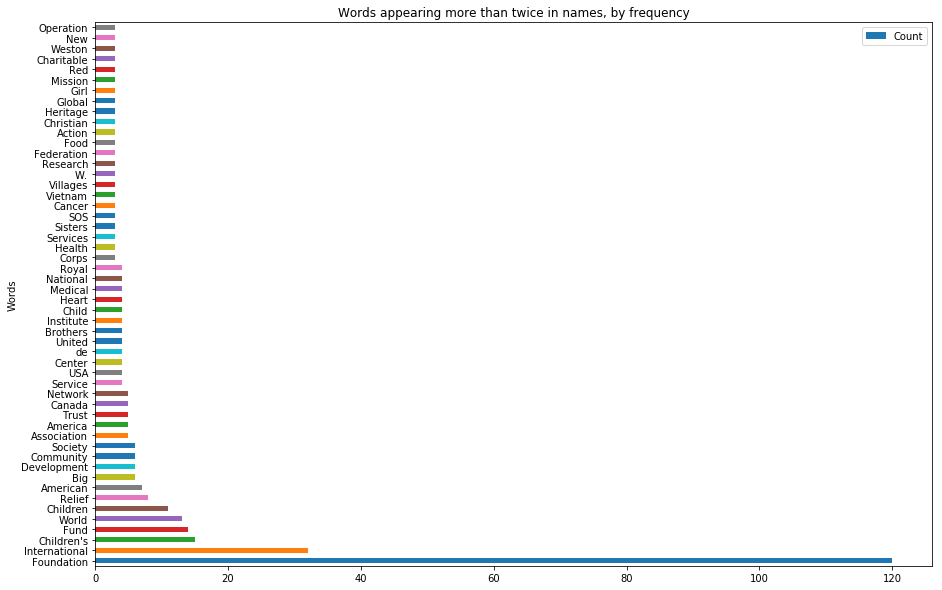

In [22]:
common_words.plot(kind='barh', x='Words', y='Count', figsize=(15, 10),
                  title='Words appearing more than twice in names, by frequency')

We can see that while there are a few "generic" words (Services, National, Association, etc...), some of the them are rather specialized (Villages, Children's, Relief, etc..). These are the ones that should help us track down charities in the panama papers or other leaked data.